# Análisis Exploratorio de Datos (EDA) - Tabla: ordenes

## Objetivo

Realizar un análisis exploratorio completo de la tabla `ordenes` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campo numérico (total) y detectar outliers
- Analizar campo temporal (fecha_orden) para identificar tendencias y patrones
- Analizar campo ENUM (estado) para verificar valores válidos
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [21]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [22]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [23]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'ordenes'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: ordenes")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: ordenes
column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                            column_default
   orden_id                     integer                     None               32.0            0.0          NO nextval('ordenes_orden_id_seq'::regclass)
 usuario_id                     integer                     None               32.0            0.0         YES                                      None
fecha_orden timestamp without time zone                     None                NaN            NaN         YES                                     now()
      total                     numeric                     None               10.0            2.0          NO                                      None
     estado                USER-DEFINED                     None                NaN            NaN         YES                 'Pendiente'::estado_orden


### 2.2. Restricciones y Claves (Constraints)


In [24]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'ordenes'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: ordenes")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CheckConstraints
query_checks = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'public.ordenes'::regclass
    AND contype = 'c';
"""

df_checks = pd.read_sql(query_checks, engine)

if not df_checks.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_checks.to_string(index=False))

# Consulta para obtener información del ENUM
query_enum = """
SELECT 
    t.typname AS enum_name,
    e.enumlabel AS enum_value
FROM pg_type t 
JOIN pg_enum e ON t.oid = e.enumtypid  
WHERE t.typname = 'estado_orden'
ORDER BY e.enumsortorder;
"""

df_enum = pd.read_sql(query_enum, engine)

if not df_enum.empty:
    print("\n" + "=" * 80)
    print("VALORES DEL ENUM: estado_orden")
    print("=" * 80)
    print(df_enum.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: ordenes
        constraint_name constraint_type column_name foreign_table_name foreign_column_name
ordenes_usuario_id_fkey     FOREIGN KEY  usuario_id           usuarios          usuario_id
           ordenes_pkey     PRIMARY KEY    orden_id            ordenes            orden_id

CHECK CONSTRAINTS
     constraint_name           constraint_definition
check_total_positivo CHECK ((total >= (0)::numeric))

VALORES DEL ENUM: estado_orden
   enum_name enum_value
estado_orden  Pendiente
estado_orden    Enviado
estado_orden Completado
estado_orden  Cancelado


In [25]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT orden_id) as ordenes_unicas,
    COUNT(DISTINCT usuario_id) as usuarios_distintos,
    COUNT(fecha_orden) as fechas_no_nulas,
    COUNT(*) - COUNT(fecha_orden) as fechas_nulas,
    MIN(total) as total_minimo,
    MAX(total) as total_maximo,
    AVG(total) as total_promedio,
    SUM(total) as total_general,
    COUNT(DISTINCT estado) as estados_distintos,
    MIN(fecha_orden) as fecha_minima,
    MAX(fecha_orden) as fecha_maxima
FROM ordenes;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: ordenes")
print("=" * 80)
print(df_stats.to_string(index=False))

# Estadísticas por estado
query_stats_estado = """
SELECT 
    estado,
    COUNT(*) as cantidad,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM ordenes), 2) as porcentaje,
    MIN(total) as total_minimo,
    MAX(total) as total_maximo,
    AVG(total) as total_promedio,
    SUM(total) as total_acumulado
FROM ordenes
GROUP BY estado
ORDER BY cantidad DESC;
"""

df_stats_estado = pd.read_sql(query_stats_estado, engine)

print("\n" + "=" * 80)
print("ESTADÍSTICAS POR ESTADO")
print("=" * 80)
print(df_stats_estado.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: ordenes
 total_registros  ordenes_unicas  usuarios_distintos  fechas_no_nulas  fechas_nulas  total_minimo  total_maximo  total_promedio  total_general  estados_distintos        fecha_minima        fecha_maxima
           10000           10000                1000            10000             0         20.11        999.99      507.762898     5077628.98                  4 2024-06-30 09:10:27 2025-06-30 09:10:27

ESTADÍSTICAS POR ESTADO
    estado  cantidad  porcentaje  total_minimo  total_maximo  total_promedio  total_acumulado
 Cancelado      2510       25.10         20.15        999.99      505.531566       1268884.23
Completado      2498       24.98         20.77        999.36      504.701097       1260743.34
   Enviado      2498       24.98         20.11        999.90      507.419672       1267534.34
 Pendiente      2494       24.94         20.94        999.96      513.419034       1280467.07


## 3. Análisis Exploratorio con Python (SQLAlchemy)


In [26]:
# Cargar la tabla completa en un DataFrame
query_ordenes = "SELECT * FROM ordenes;"
df_ordenes = pd.read_sql(query_ordenes, engine)

# Convertir fecha_orden a datetime si no lo está
if 'fecha_orden' in df_ordenes.columns:
    df_ordenes['fecha_orden'] = pd.to_datetime(df_ordenes['fecha_orden'])

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_ordenes.shape}")
print(f"Columnas: {list(df_ordenes.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_ordenes.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (10000, 5)
Columnas: ['orden_id', 'usuario_id', 'fecha_orden', 'total', 'estado']

Primeras 10 filas:
   orden_id  usuario_id         fecha_orden   total      estado
0         1         153 2024-09-09 09:10:27  393.81     Enviado
1         2         810 2024-09-29 09:10:27  918.85  Completado
2         3         404 2024-11-03 09:10:27  391.29   Pendiente
3         4          52 2024-09-14 09:10:27  250.03   Cancelado
4         5         811 2025-04-11 09:10:27  983.13  Completado
5         6         500 2025-06-26 09:10:27  713.98   Pendiente
6         7         357 2024-08-14 09:10:27  540.25     Enviado
7         8         486 2025-04-17 09:10:27  972.60  Completado
8         9         862 2024-08-03 09:10:27   78.71   Pendiente
9        10          58 2024-08-26 09:10:27  218.77  Completado


### 3.1. Información General del DataFrame


In [27]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_ordenes.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_ordenes.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_ordenes.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   orden_id     10000 non-null  int64         
 1   usuario_id   10000 non-null  int64         
 2   fecha_orden  10000 non-null  datetime64[ns]
 3   total        10000 non-null  float64       
 4   estado       10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 390.8+ KB

TIPOS DE DATOS POR COLUMNA
orden_id                int64
usuario_id              int64
fecha_orden    datetime64[ns]
total                 float64
estado                 object
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
           orden_id    usuario_id                    fecha_orden  \
count   10000.00000  10000.000000                          10000   
unique          NaN           NaN                            NaN   
top       

### 3.2. Detección de Valores Nulos


In [28]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_ordenes.isnull().sum()
porcentaje_nulos = (df_ordenes.isnull().sum() / len(df_ordenes)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_ordenes.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_ordenes.columns:
        nulos_col = df_ordenes[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_ordenes)*100:.1f}%)")


ANÁLISIS DE VALORES NULOS
    Columna  Cantidad_Nulos  Porcentaje_Nulos
   orden_id               0               0.0
 usuario_id               0               0.0
fecha_orden               0               0.0
      total               0               0.0
     estado               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [29]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_ordenes.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por orden_id (clave primaria)
duplicados_orden_id = df_ordenes['orden_id'].duplicated().sum()
print(f"Duplicados en orden_id (PK): {duplicados_orden_id}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_ordenes[df_ordenes.duplicated(keep=False)]
    print(duplicados.sort_values('orden_id'))

if duplicados_completos == 0 and duplicados_orden_id == 0:
    print("\n✓ No se encontraron duplicados en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en orden_id (PK): 0

✓ No se encontraron duplicados en la tabla.


### 3.4. Análisis de Campo Numérico (Total)


In [30]:
# Análisis del campo numérico total
print("=" * 80)
print("ANÁLISIS DEL CAMPO NUMÉRICO: total")
print("=" * 80)

valores = df_ordenes['total']

print(f"Estadísticas descriptivas:")
print(f"  Mínimo: {valores.min()}")
print(f"  Máximo: {valores.max()}")
print(f"  Media: {valores.mean():.2f}")
print(f"  Mediana: {valores.median():.2f}")
print(f"  Desviación estándar: {valores.std():.2f}")
print(f"  Q1 (25%): {valores.quantile(0.25):.2f}")
print(f"  Q3 (75%): {valores.quantile(0.75):.2f}")
print(f"  IQR: {valores.quantile(0.75) - valores.quantile(0.25):.2f}")

# Valores negativos (violan constraint)
valores_negativos = df_ordenes[df_ordenes['total'] < 0]
if len(valores_negativos) > 0:
    print(f"\n  ⚠ Valores negativos (violan constraint): {len(valores_negativos)}")
    print(valores_negativos[['orden_id', 'usuario_id', 'total', 'estado']])
else:
    print(f"\n  ✓ No hay valores negativos")

# Valores cero
valores_cero = df_ordenes[df_ordenes['total'] == 0]
if len(valores_cero) > 0:
    print(f"\n  ⚠ Valores iguales a cero: {len(valores_cero)}")
    print(f"    Esto puede indicar órdenes canceladas o errores de datos")
    print(valores_cero[['orden_id', 'usuario_id', 'total', 'estado']].head(10))

# Detección de outliers usando IQR
Q1 = valores.quantile(0.25)
Q3 = valores.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_ordenes[(df_ordenes['total'] < limite_inferior) | (df_ordenes['total'] > limite_superior)]
if len(outliers) > 0:
    print(f"\n  ⚠ Valores atípicos (outliers) detectados: {len(outliers)}")
    print(f"    Límite inferior: {limite_inferior:.2f}")
    print(f"    Límite superior: {limite_superior:.2f}")
    print(f"    Ejemplos de outliers:")
    print(outliers[['orden_id', 'usuario_id', 'total', 'estado']].head(10))
else:
    print(f"\n  ✓ No se detectaron outliers significativos")


ANÁLISIS DEL CAMPO NUMÉRICO: total
Estadísticas descriptivas:
  Mínimo: 20.11
  Máximo: 999.99
  Media: 507.76
  Mediana: 506.79
  Desviación estándar: 281.77
  Q1 (25%): 262.92
  Q3 (75%): 750.38
  IQR: 487.47

  ✓ No hay valores negativos

  ✓ No se detectaron outliers significativos


### 3.5. Análisis de Campo Temporal (fecha_orden)


In [31]:
# Análisis del campo temporal fecha_orden
print("=" * 80)
print("ANÁLISIS DEL CAMPO TEMPORAL: fecha_orden")
print("=" * 80)

if 'fecha_orden' in df_ordenes.columns:
    fechas_no_nulas = df_ordenes['fecha_orden'].dropna()
    
    if len(fechas_no_nulas) > 0:
        print(f"Total de fechas no nulas: {len(fechas_no_nulas)}")
        print(f"Fecha mínima: {fechas_no_nulas.min()}")
        print(f"Fecha máxima: {fechas_no_nulas.max()}")
        print(f"Rango temporal: {(fechas_no_nulas.max() - fechas_no_nulas.min()).days} días")
        
        # Análisis de fechas futuras (anomalías)
        fecha_actual = pd.Timestamp.now()
        fechas_futuras = df_ordenes[df_ordenes['fecha_orden'] > fecha_actual]
        if len(fechas_futuras) > 0:
            print(f"\n⚠ Fechas futuras detectadas: {len(fechas_futuras)}")
            print(fechas_futuras[['orden_id', 'usuario_id', 'fecha_orden', 'total']].head(10))
        else:
            print(f"\n✓ No se encontraron fechas futuras")
        
        # Análisis de fechas muy antiguas (posibles errores)
        fecha_limite_antigua = pd.Timestamp('2000-01-01')
        fechas_antiguas = df_ordenes[df_ordenes['fecha_orden'] < fecha_limite_antigua]
        if len(fechas_antiguas) > 0:
            print(f"\n⚠ Fechas muy antiguas (< 2000) detectadas: {len(fechas_antiguas)}")
            print(fechas_antiguas[['orden_id', 'usuario_id', 'fecha_orden', 'total']].head(10))
        
        # Distribución por año
        print("\nDistribución de órdenes por año:")
        df_ordenes['año'] = df_ordenes['fecha_orden'].dt.year
        distribucion_año = df_ordenes['año'].value_counts().sort_index()
        print(distribucion_año)
        
        # Distribución por mes (del año más reciente)
        año_mas_reciente = df_ordenes['año'].max()
        df_año_reciente = df_ordenes[df_ordenes['año'] == año_mas_reciente]
        if len(df_año_reciente) > 0:
            print(f"\nDistribución de órdenes por mes (año {año_mas_reciente}):")
            df_año_reciente['mes'] = df_año_reciente['fecha_orden'].dt.month
            distribucion_mes = df_año_reciente['mes'].value_counts().sort_index()
            print(distribucion_mes)
        
        # Distribución por día de la semana
        df_ordenes['dia_semana'] = df_ordenes['fecha_orden'].dt.day_name()
        print(f"\nDistribución de órdenes por día de la semana:")
        distribucion_dia = df_ordenes['dia_semana'].value_counts()
        print(distribucion_dia)
    else:
        print("⚠ Todas las fechas son nulas")
else:
    print("⚠ La columna fecha_orden no existe en el DataFrame")


ANÁLISIS DEL CAMPO TEMPORAL: fecha_orden
Total de fechas no nulas: 10000
Fecha mínima: 2024-06-30 09:10:27
Fecha máxima: 2025-06-30 09:10:27
Rango temporal: 365 días

✓ No se encontraron fechas futuras

Distribución de órdenes por año:
año
2024    5015
2025    4985
Name: count, dtype: int64

Distribución de órdenes por mes (año 2025):
mes
1    844
2    747
3    842
4    893
5    861
6    798
Name: count, dtype: int64

Distribución de órdenes por día de la semana:
dia_semana
Sunday       1517
Saturday     1486
Monday       1415
Wednesday    1412
Friday       1407
Tuesday      1385
Thursday     1378
Name: count, dtype: int64


In [32]:
# Análisis del campo ENUM estado
print("=" * 80)
print("ANÁLISIS DEL CAMPO ENUM: estado")
print("=" * 80)

if 'estado' in df_ordenes.columns:
    # Valores únicos
    valores_unicos = df_ordenes['estado'].unique()
    print(f"Valores únicos encontrados: {sorted(valores_unicos)}")
    
    # Distribución de valores
    print("\nDistribución de estados:")
    distribucion_estado = df_ordenes['estado'].value_counts()
    porcentaje_estado = (df_ordenes['estado'].value_counts() / len(df_ordenes)) * 100
    
    df_estado = pd.DataFrame({
        'Estado': distribucion_estado.index,
        'Cantidad': distribucion_estado.values,
        'Porcentaje': porcentaje_estado.values
    })
    print(df_estado.to_string(index=False))
    
    # Verificar valores inválidos (comparar con ENUM definido)
    if not df_enum.empty:
        valores_validos = set(df_enum['enum_value'].tolist())
        valores_encontrados = set(df_ordenes['estado'].dropna().unique())
        valores_invalidos = valores_encontrados - valores_validos
        
        if len(valores_invalidos) > 0:
            print(f"\n⚠ Valores inválidos detectados: {valores_invalidos}")
            for valor_invalido in valores_invalidos:
                cantidad = len(df_ordenes[df_ordenes['estado'] == valor_invalido])
                print(f"  - '{valor_invalido}': {cantidad} registros")
        else:
            print(f"\n✓ Todos los valores de estado son válidos según el ENUM")
    
    # Análisis de estados nulos
    estados_nulos = df_ordenes['estado'].isnull().sum()
    if estados_nulos > 0:
        print(f"\n⚠ Estados nulos: {estados_nulos}")
    else:
        print(f"\n✓ No hay estados nulos")
else:
    print("⚠ La columna estado no existe en el DataFrame")


ANÁLISIS DEL CAMPO ENUM: estado
Valores únicos encontrados: ['Cancelado', 'Completado', 'Enviado', 'Pendiente']

Distribución de estados:
    Estado  Cantidad  Porcentaje
 Cancelado      2510       25.10
   Enviado      2498       24.98
Completado      2498       24.98
 Pendiente      2494       24.94

✓ Todos los valores de estado son válidos según el ENUM

✓ No hay estados nulos


### 3.7. Análisis de Relación con Usuarios


In [43]:
# Análisis de relación con usuarios
print("=" * 80)
print("ANÁLISIS DE RELACIÓN CON USUARIOS")
print("=" * 80)

# Verificar valores nulos en usuario_id
usuario_id_nulos = df_ordenes['usuario_id'].isnull().sum()
print(f"Órdenes con usuario_id nulo: {usuario_id_nulos}")

if usuario_id_nulos > 0:
    print("⚠ ADVERTENCIA: Órdenes sin usuario asignado:")
    print(df_ordenes[df_ordenes['usuario_id'].isnull()][['orden_id', 'fecha_orden', 'total', 'estado']])

# Distribución de órdenes por usuario
print("\nDistribución de órdenes por usuario:")
distribucion_usuario = df_ordenes['usuario_id'].value_counts()
print(f"Usuarios distintos con órdenes: {distribucion_usuario.nunique()}")
print(f"Promedio de órdenes por usuario: {distribucion_usuario.mean():.2f}")
print(f"Máximo de órdenes por usuario: {distribucion_usuario.max()}")
print(f"Mínimo de órdenes por usuario: {distribucion_usuario.min()}")

# Top 10 usuarios con más órdenes
print("\nTop 10 usuarios con más órdenes:")
print(distribucion_usuario.head(10))

# Verificar referencias huérfanas (usuario_id que no existe en usuarios)
query_orphan = """
SELECT COUNT(*) as huérfanas
FROM ordenes o
LEFT JOIN usuarios u ON o.usuario_id = u.usuario_id
WHERE o.usuario_id IS NOT NULL AND u.usuario_id IS NULL;
"""

df_orphan = pd.read_sql(query_orphan, engine)
huérfanas = df_orphan['huérfanas'].iloc[0]

if huérfanas > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas} referencias huérfanas (usuario_id que no existe en usuarios)")
    query_orphan_detalle = """
    SELECT o.orden_id, o.usuario_id, o.fecha_orden, o.total, o.estado
    FROM ordenes o
    LEFT JOIN usuarios u ON o.usuario_id = u.usuario_id
    WHERE o.usuario_id IS NOT NULL AND u.usuario_id IS NULL
    LIMIT 10;
    """
    df_orphan_detalle = pd.read_sql(query_orphan_detalle, engine)
    print(df_orphan_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas.")


ANÁLISIS DE RELACIÓN CON USUARIOS
Órdenes con usuario_id nulo: 0

Distribución de órdenes por usuario:
Usuarios distintos con órdenes: 19
Promedio de órdenes por usuario: 10.00
Máximo de órdenes por usuario: 19
Mínimo de órdenes por usuario: 1

Top 10 usuarios con más órdenes:
usuario_id
540    19
940    19
710    19
770    19
843    18
329    18
411    18
777    17
878    17
248    17
Name: count, dtype: int64

✓ No se encontraron referencias huérfanas.


### 3.8. Detección de Valores Atípicos y Anomalías


In [34]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Totales muy altos o muy bajos
total_promedio = df_ordenes['total'].mean()
total_std = df_ordenes['total'].std()
totales_muy_altos = df_ordenes[df_ordenes['total'] > total_promedio + 3 * total_std]
totales_muy_bajos = df_ordenes[df_ordenes['total'] < total_promedio - 3 * total_std]

if len(totales_muy_altos) > 0:
    print(f"⚠ Totales muy altos (> media + 3*std): {len(totales_muy_altos)}")
    anomalias.append(('Totales muy altos', len(totales_muy_altos)))
    print(totales_muy_altos[['orden_id', 'usuario_id', 'total', 'estado']].head(10))

if len(totales_muy_bajos) > 0:
    print(f"\n⚠ Totales muy bajos (< media - 3*std): {len(totales_muy_bajos)}")
    anomalias.append(('Totales muy bajos', len(totales_muy_bajos)))
    print(totales_muy_bajos[['orden_id', 'usuario_id', 'total', 'estado']].head(10))

# 2. Órdenes con total cero
ordenes_total_cero = df_ordenes[df_ordenes['total'] == 0]
if len(ordenes_total_cero) > 0:
    print(f"\n⚠ Órdenes con total cero: {len(ordenes_total_cero)}")
    anomalias.append(('Total cero', len(ordenes_total_cero)))
    print(ordenes_total_cero[['orden_id', 'usuario_id', 'total', 'estado']].head(10))

# 3. Órdenes sin usuario
ordenes_sin_usuario = df_ordenes[df_ordenes['usuario_id'].isnull()]
if len(ordenes_sin_usuario) > 0:
    print(f"\n⚠ Órdenes sin usuario asignado: {len(ordenes_sin_usuario)}")
    anomalias.append(('Sin usuario', len(ordenes_sin_usuario)))
    print(ordenes_sin_usuario[['orden_id', 'fecha_orden', 'total', 'estado']])

# 4. Fechas futuras (si se detectaron anteriormente)
if 'fecha_orden' in df_ordenes.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_ordenes[df_ordenes['fecha_orden'] > fecha_actual]
    if len(fechas_futuras) > 0:
        print(f"\n⚠ Fechas futuras: {len(fechas_futuras)}")
        anomalias.append(('Fechas futuras', len(fechas_futuras)))
        print(fechas_futuras[['orden_id', 'usuario_id', 'fecha_orden', 'total']].head(10))

# 5. Estados inválidos (si se detectaron anteriormente)
if 'estado' in df_ordenes.columns and not df_enum.empty:
    valores_validos = set(df_enum['enum_value'].tolist())
    valores_encontrados = set(df_ordenes['estado'].dropna().unique())
    valores_invalidos = valores_encontrados - valores_validos
    if len(valores_invalidos) > 0:
        print(f"\n⚠ Estados inválidos: {len(valores_invalidos)} tipos")
        anomalias.append(('Estados inválidos', len(valores_invalidos)))
        for valor_invalido in valores_invalidos:
            cantidad = len(df_ordenes[df_ordenes['estado'] == valor_invalido])
            print(f"  - '{valor_invalido}': {cantidad} registros")

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

✓ No se detectaron anomalías significativas.


## 4. Identificación de Claves Primarias y Foráneas


In [35]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - orden_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_ordenes['orden_id'].min()} a {df_ordenes['orden_id'].max()}")
print(f"   - Valores únicos: {df_ordenes['orden_id'].nunique()}")
print(f"   - Total de registros: {len(df_ordenes)}")
print(f"   - ¿Sin duplicados?: {df_ordenes['orden_id'].nunique() == len(df_ordenes)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_ordenes['orden_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Gaps: {gaps}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Clave foránea
print("\n2. CLAVE FORÁNEA:")
print("   - usuario_id: FOREIGN KEY → usuarios.usuario_id")
usuario_id_nulos = df_ordenes['usuario_id'].isnull().sum()
print(f"   - Valores nulos: {usuario_id_nulos}")
print(f"   - Usuarios distintos: {df_ordenes['usuario_id'].nunique()}")

# Claves foráneas que referencian esta tabla
print("\n3. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:")
print("   (Verificar en otras tablas)")

tablas_relacionadas = ['detalle_ordenes', 'ordenes_metodos_pago', 'historial_pagos']
for tabla in tablas_relacionadas:
    try:
        query_fk = f"""
        SELECT COUNT(*) as total
        FROM {tabla}
        WHERE orden_id IS NOT NULL;
        """
        df_fk = pd.read_sql(query_fk, engine)
        total_refs = df_fk['total'].iloc[0]
        
        # Verificar referencias huérfanas
        query_orphan = f"""
        SELECT COUNT(*) as huérfanas
        FROM {tabla} t
        LEFT JOIN ordenes o ON t.orden_id = o.orden_id
        WHERE t.orden_id IS NOT NULL AND o.orden_id IS NULL;
        """
        df_orphan = pd.read_sql(query_orphan, engine)
        huérfanas = df_orphan['huérfanas'].iloc[0]
        
        # Verificar órdenes sin referencias
        query_sin_refs = f"""
        SELECT o.orden_id, o.usuario_id, o.total, o.estado
        FROM ordenes o
        LEFT JOIN {tabla} t ON o.orden_id = t.orden_id
        WHERE t.orden_id IS NULL
        ORDER BY o.orden_id
        LIMIT 10;
        """
        df_sin_refs = pd.read_sql(query_sin_refs, engine)
        
        print(f"   - {tabla}.orden_id: {total_refs} referencias")
        if huérfanas > 0:
            print(f"     ⚠ Referencias huérfanas: {huérfanas}")
        if len(df_sin_refs) > 0:
            print(f"     - Órdenes sin referencias en {tabla}: {len(df_sin_refs)} (mostrando primeros 10)")
    except Exception as e:
        print(f"   - {tabla}: No se pudo verificar ({str(e)})")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - orden_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 10000
   - Valores únicos: 10000
   - Total de registros: 10000
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVE FORÁNEA:
   - usuario_id: FOREIGN KEY → usuarios.usuario_id
   - Valores nulos: 0
   - Usuarios distintos: 1000

3. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:
   (Verificar en otras tablas)
   - detalle_ordenes.orden_id: 10000 referencias
     - Órdenes sin referencias en detalle_ordenes: 10 (mostrando primeros 10)
   - ordenes_metodos_pago.orden_id: 10000 referencias
   - historial_pagos.orden_id: 10000 referencias


In [36]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['estado']  # Solo campos de texto que puedan contener estructuras

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    valores_no_nulos = df_ordenes[campo].dropna()
    if len(valores_no_nulos) > 0:
        json_pattern = r'\{.*\}|\[.*\]'
        tiene_json = valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True).sum()
        if tiene_json > 0:
            print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
            json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    valores_no_nulos = df_ordenes[campo].dropna()
    if len(valores_no_nulos) > 0:
        for delim in delimitadores:
            tiene_delim = valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False).sum()
            if tiene_delim > 0:
                print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                delimitadores_encontrados = True
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'ordenes' no contiene campos explícitamente semi-estructurados (JSON, listas).")
print("El campo 'estado' es un ENUM y está correctamente estructurado.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores estructurados

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'ordenes' no contiene campos explícitamente semi-estructurados (JSON, listas).
El campo 'estado' es un ENUM y está correctamente estructurado.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


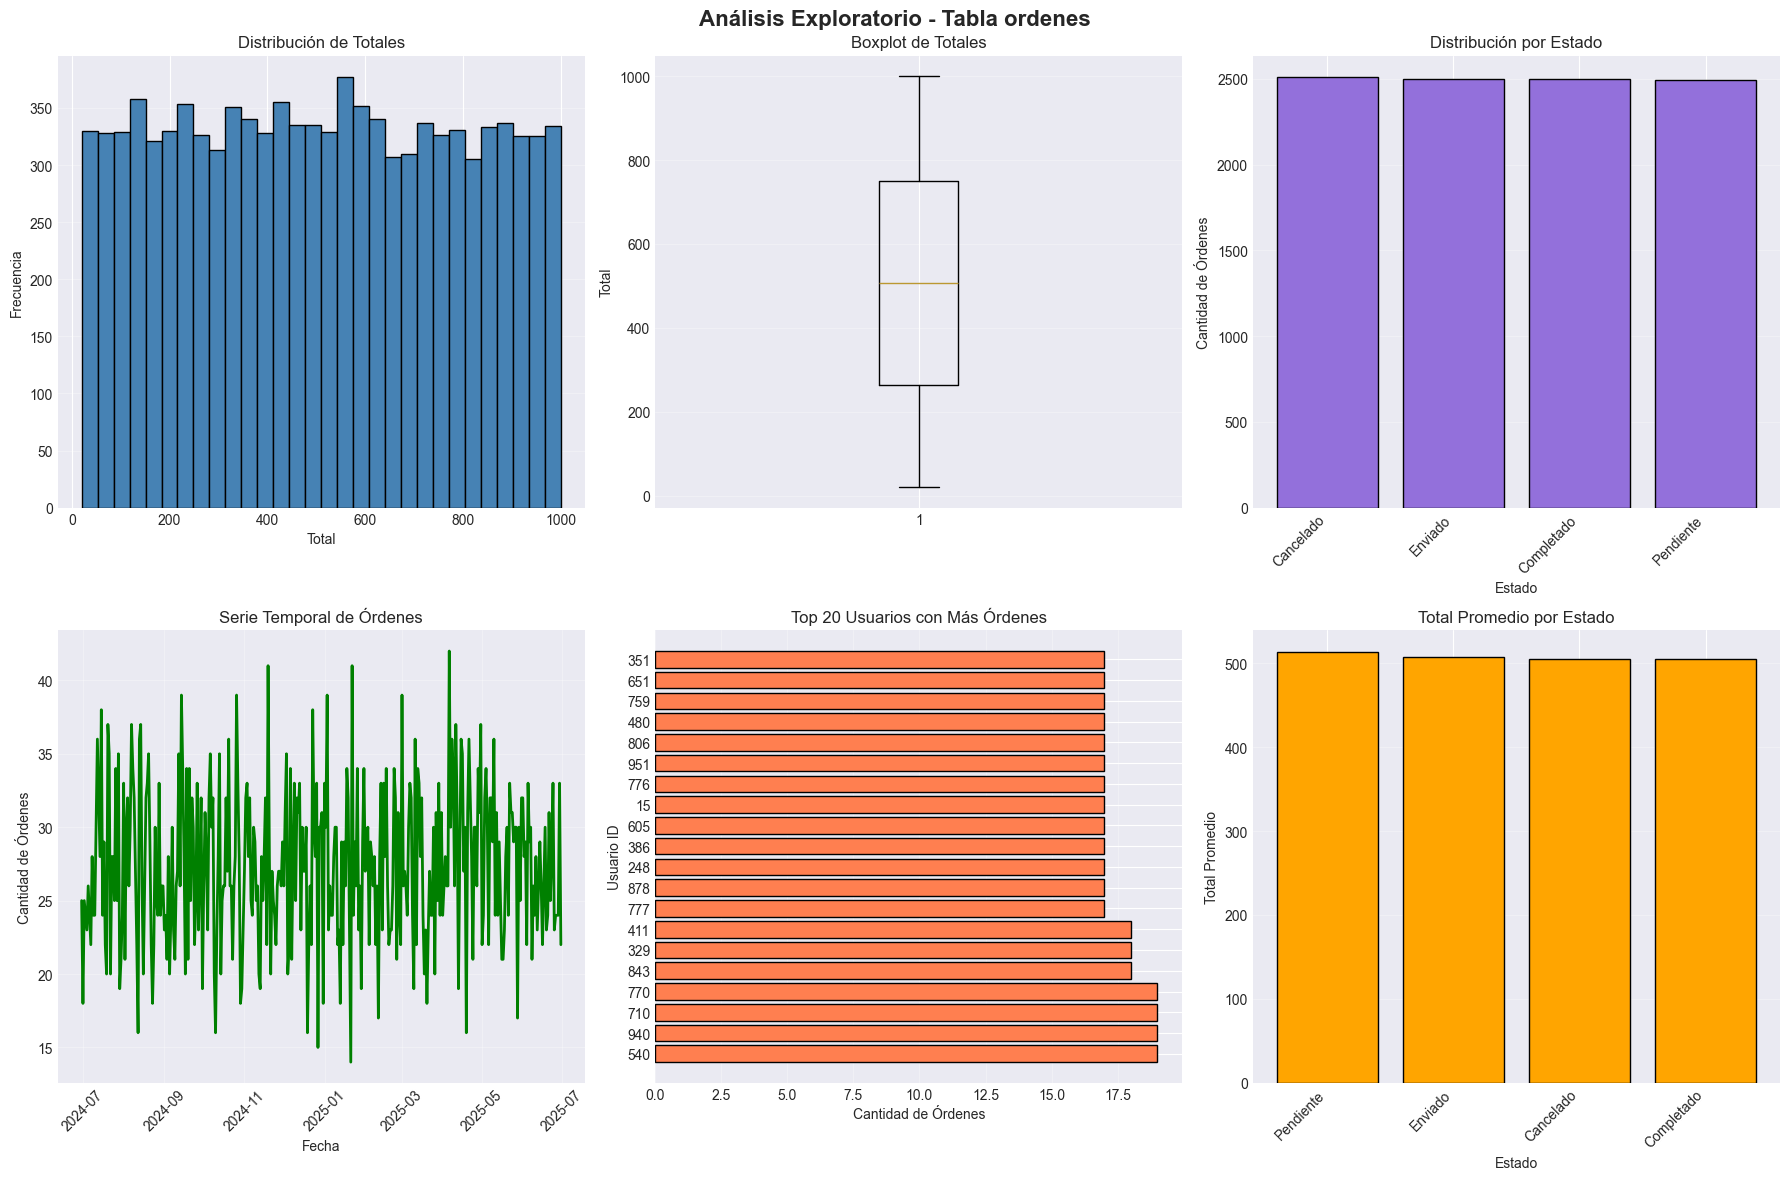

✓ Visualizaciones generadas correctamente


In [37]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla ordenes', fontsize=16, fontweight='bold')

# 1. Distribución de totales
ax1 = axes[0, 0]
ax1.hist(df_ordenes['total'], bins=30, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Totales')
ax1.set_xlabel('Total')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Boxplot de totales
ax2 = axes[0, 1]
ax2.boxplot(df_ordenes['total'], vert=True)
ax2.set_title('Boxplot de Totales')
ax2.set_ylabel('Total')
ax2.grid(axis='y', alpha=0.3)

# 3. Distribución por estado
ax3 = axes[0, 2]
distribucion_estado = df_ordenes['estado'].value_counts()
ax3.bar(range(len(distribucion_estado)), distribucion_estado.values, color='mediumpurple', edgecolor='black')
ax3.set_title('Distribución por Estado')
ax3.set_xlabel('Estado')
ax3.set_ylabel('Cantidad de Órdenes')
ax3.set_xticks(range(len(distribucion_estado)))
ax3.set_xticklabels(distribucion_estado.index, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. Serie temporal de órdenes (si hay fecha_orden)
if 'fecha_orden' in df_ordenes.columns:
    ax4 = axes[1, 0]
    df_ordenes['fecha_orden'] = pd.to_datetime(df_ordenes['fecha_orden'])
    df_ordenes_por_fecha = df_ordenes.groupby(df_ordenes['fecha_orden'].dt.date).size()
    ax4.plot(df_ordenes_por_fecha.index, df_ordenes_por_fecha.values, color='green', linewidth=2)
    ax4.set_title('Serie Temporal de Órdenes')
    ax4.set_xlabel('Fecha')
    ax4.set_ylabel('Cantidad de Órdenes')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(alpha=0.3)
else:
    ax4 = axes[1, 0]
    ax4.text(0.5, 0.5, 'No hay datos de fecha', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Serie Temporal de Órdenes')

# 5. Distribución de órdenes por usuario (top 20)
ax5 = axes[1, 1]
distribucion_usuario = df_ordenes['usuario_id'].value_counts().head(20)
ax5.barh(range(len(distribucion_usuario)), distribucion_usuario.values, color='coral', edgecolor='black')
ax5.set_title('Top 20 Usuarios con Más Órdenes')
ax5.set_xlabel('Cantidad de Órdenes')
ax5.set_ylabel('Usuario ID')
ax5.set_yticks(range(len(distribucion_usuario)))
ax5.set_yticklabels(distribucion_usuario.index)
ax5.grid(axis='x', alpha=0.3)

# 6. Total promedio por estado
ax6 = axes[1, 2]
total_por_estado = df_ordenes.groupby('estado')['total'].mean().sort_values(ascending=False)
ax6.bar(range(len(total_por_estado)), total_por_estado.values, color='orange', edgecolor='black')
ax6.set_title('Total Promedio por Estado')
ax6.set_xlabel('Estado')
ax6.set_ylabel('Total Promedio')
ax6.set_xticks(range(len(total_por_estado)))
ax6.set_xticklabels(total_por_estado.index, rotation=45, ha='right')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


## 7. Reporte de Hallazgos y Decisiones


### 7.1. Principales Insights y Problemas Encontrados


In [38]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: ordenes")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_ordenes.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    ordenes_total_cero = df_ordenes[df_ordenes['total'] == 0]
    if len(ordenes_total_cero) > 0:
        anomalias.append(('Total cero', len(ordenes_total_cero)))
    ordenes_sin_usuario = df_ordenes[df_ordenes['usuario_id'].isnull()]
    if len(ordenes_sin_usuario) > 0:
        anomalias.append(('Sin usuario', len(ordenes_sin_usuario)))

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_ordenes))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_ordenes.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_ordenes['orden_id'].nunique() == len(df_ordenes) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_ordenes)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Órdenes sin usuario
usuario_id_nulos = df_ordenes['usuario_id'].isnull().sum()
if usuario_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Órdenes sin usuario asignado: {usuario_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar usuario a órdenes sin usuario o eliminar si son inválidas'
    })

# Órdenes con total cero
ordenes_total_cero = df_ordenes[df_ordenes['total'] == 0]
if len(ordenes_total_cero) > 0:
    problemas.append({
        'Categoría': 'Validación de Negocio',
        'Problema': f'Órdenes con total cero: {len(ordenes_total_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar si las órdenes con total cero son cancelaciones o errores'
    })

# Estados inválidos
if 'estado' in df_ordenes.columns and not df_enum.empty:
    valores_validos = set(df_enum['enum_value'].tolist())
    valores_encontrados = set(df_ordenes['estado'].dropna().unique())
    valores_invalidos = valores_encontrados - valores_validos
    if len(valores_invalidos) > 0:
        problemas.append({
            'Categoría': 'Validación de ENUM',
            'Problema': f'Estados inválidos detectados: {valores_invalidos}',
            'Severidad': 'Alta',
            'Acción Requerida': 'Corregir estados inválidos según el ENUM definido'
        })

# Fechas futuras
if 'fecha_orden' in df_ordenes.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_ordenes[df_ordenes['fecha_orden'] > fecha_actual]
    if len(fechas_futuras) > 0:
        problemas.append({
            'Categoría': 'Validación Temporal',
            'Problema': f'Órdenes con fechas futuras: {len(fechas_futuras)}',
            'Severidad': 'Media',
            'Acción Requerida': 'Revisar y corregir fechas futuras'
        })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Total cero', 'Sin usuario']:  # Ya incluidos arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'orden_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único de la orden',
        'Uso': 'Relaciones con detalles, métodos de pago, historial de pagos'
    },
    {
        'Atributo': 'usuario_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica al cliente que realizó la orden',
        'Uso': 'Análisis de clientes, historial de compras, segmentación'
    },
    {
        'Atributo': 'fecha_orden',
        'Tipo': 'Campo Temporal',
        'Relevancia Negocio': 'Alta - Fecha y hora de creación de la orden',
        'Uso': 'Análisis temporal, tendencias, análisis de estacionalidad'
    },
    {
        'Atributo': 'total',
        'Tipo': 'Métrica de Negocio',
        'Relevancia Negocio': 'Alta - Monto total de la orden',
        'Uso': 'Análisis de ingresos, rentabilidad, valor promedio de orden'
    },
    {
        'Atributo': 'estado',
        'Tipo': 'Campo ENUM',
        'Relevancia Negocio': 'Alta - Estado actual de la orden',
        'Uso': 'Seguimiento de órdenes, análisis de conversión, gestión de inventario'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'ordenes' tiene:")
print("   - usuario_id → usuarios.usuario_id (relación N:1)")
print("   - Es referenciada por:")
print("     - detalle_ordenes.orden_id (relación 1:N)")
print("     - ordenes_metodos_pago.orden_id (relación 1:N)")
print("     - historial_pagos.orden_id (relación 1:N)")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: ordenes

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 10000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
   ✓ No se detectaron problemas significativos

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
   Atributo               Tipo                                Relevancia Negocio                                                                   Uso
   orden_id     Clave Primaria            Alta - Identificador único de la orden          Relaciones con detalles, métodos de pago, historial de pagos
 usuario_id      Clave Foránea Alta - Identifica al cliente que realizó la orden              Análisis de clientes, historial de compras, segmentación
fecha_orden     Campo Temporal       Alta - Fecha y hora de creación de la orden             Análisis temporal, tendencias, análisis de estacionalidad
      total Métrica de Negocio                    Alta - Monto total 

### 7.2. Decisiones Tomadas Respecto a Limpieza y Transformación


In [39]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos
if total_nulos > 0:
    decisiones.append({
        'Aspecto': 'Valores Nulos',
        'Decisión': 'Revisar y corregir valores nulos según corresponda.',
        'Justificación': f'Se encontraron {total_nulos} valores nulos en la tabla.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos',
        'Decisión': 'No se requieren acciones. La tabla no contiene valores nulos.',
        'Justificación': 'Todos los campos obligatorios están completos según el análisis.',
        'Prioridad': 'N/A'
    })

# 2. Duplicados
decisiones.append({
    'Aspecto': 'Duplicados',
    'Decisión': 'No se requieren acciones. No se encontraron duplicados completos.',
    'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
    'Prioridad': 'N/A'
})

# 3. Órdenes sin usuario
usuario_id_nulos = df_ordenes['usuario_id'].isnull().sum()
if usuario_id_nulos > 0:
    decisiones.append({
        'Aspecto': 'Órdenes sin Usuario',
        'Decisión': 'Asignar usuario a órdenes sin usuario o eliminar si son inválidas.',
        'Justificación': f'Se encontraron {usuario_id_nulos} órdenes sin usuario asignado.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Órdenes sin Usuario',
        'Decisión': 'No se requieren acciones. Todas las órdenes tienen usuario.',
        'Justificación': 'Todas las órdenes tienen un usuario asignado.',
        'Prioridad': 'N/A'
    })

# 4. Órdenes con total cero
ordenes_total_cero = df_ordenes[df_ordenes['total'] == 0]
if len(ordenes_total_cero) > 0:
    decisiones.append({
        'Aspecto': 'Totales Cero',
        'Decisión': 'Revisar órdenes con total cero. Pueden ser cancelaciones o errores.',
        'Justificación': f'Se encontraron {len(ordenes_total_cero)} órdenes con total cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Totales Cero',
        'Decisión': 'No se requieren acciones. No hay órdenes con total cero.',
        'Justificación': 'Todas las órdenes tienen un total mayor a cero.',
        'Prioridad': 'N/A'
    })

# 5. Validación de estados
if 'estado' in df_ordenes.columns and not df_enum.empty:
    valores_validos = set(df_enum['enum_value'].tolist())
    valores_encontrados = set(df_ordenes['estado'].dropna().unique())
    valores_invalidos = valores_encontrados - valores_validos
    if len(valores_invalidos) > 0:
        decisiones.append({
            'Aspecto': 'Estados Inválidos',
            'Decisión': 'Corregir estados inválidos según el ENUM definido.',
            'Justificación': f'Se encontraron estados inválidos: {valores_invalidos}',
            'Prioridad': 'Alta'
        })
    else:
        decisiones.append({
            'Aspecto': 'Estados Inválidos',
            'Decisión': 'No se requieren acciones. Todos los estados son válidos.',
            'Justificación': 'Todos los estados coinciden con el ENUM definido.',
            'Prioridad': 'N/A'
        })

# 6. Validación de fechas
if 'fecha_orden' in df_ordenes.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_ordenes[df_ordenes['fecha_orden'] > fecha_actual]
    if len(fechas_futuras) > 0:
        decisiones.append({
            'Aspecto': 'Fechas Futuras',
            'Decisión': 'Revisar y corregir fechas futuras.',
            'Justificación': f'Se encontraron {len(fechas_futuras)} órdenes con fechas futuras.',
            'Prioridad': 'Media'
        })
    else:
        decisiones.append({
            'Aspecto': 'Fechas Futuras',
            'Decisión': 'No se requieren acciones. No hay fechas futuras.',
            'Justificación': 'Todas las fechas son válidas.',
            'Prioridad': 'N/A'
        })

# 7. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                  Aspecto                                                                        Decisión                                                                         Justificación Prioridad
            Valores Nulos                   No se requieren acciones. La tabla no contiene valores nulos.                      Todos los campos obligatorios están completos según el análisis.       N/A
               Duplicados               No se requieren acciones. No se encontraron duplicados completos.                  Las restricciones de clave primaria están funcionando correctamente.       N/A
      Órdenes sin Usuario                     No se requieren acciones. Todas las órdenes tienen usuario.                                         Todas las órdenes tienen un usuario asignado.       N/A
             Totales Cero                        No se requieren acciones. No hay órdenes con total cero.                                       Todas la

In [40]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: ordenes")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'ordenes' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'ordenes' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'ordenes' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'ordenes'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'ordenes',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'usuarios',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Una orden pertenece a un usuario'
    },
    {
        'Tabla Origen': 'ordenes',
        'Columna Origen': 'orden_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'detalle_ordenes',
        'Columna Destino': 'orden_id',
        'Descripción': 'Una orden puede tener múltiples detalles'
    },
    {
        'Tabla Origen': 'ordenes',
        'Columna Origen': 'orden_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'ordenes_metodos_pago',
        'Columna Destino': 'orden_id',
        'Descripción': 'Una orden puede tener múltiples métodos de pago'
    },
    {
        'Tabla Origen': 'ordenes',
        'Columna Origen': 'orden_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'historial_pagos',
        'Columna Destino': 'orden_id',
        'Descripción': 'Una orden puede tener múltiples registros en historial de pagos'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_ordenes)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: orden_id")
print(f"Clave foránea: usuario_id")
print(f"Relaciones salientes: {len([r for r in relaciones if r['Tipo Relación'] == '1:N'])}")
print(f"Relaciones entrantes: {len([r for r in relaciones if r['Tipo Relación'] == 'N:1'])}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_ordenes.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: ordenes

ESTRUCTURA DE COLUMNAS:
column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                            column_default constraints
   orden_id                     integer                     None               32.0            0.0          NO nextval('ordenes_orden_id_seq'::regclass) PRIMARY KEY
 usuario_id                     integer                     None               32.0            0.0         YES                                      None FOREIGN KEY
fecha_orden timestamp without time zone                     None                NaN            NaN         YES                                     now()            
      total                     numeric                     None               10.0            2.0          NO                                      None            
     estado                USER-DEFINED                     None                NaN            NaN         YES                 'P

## 8. Conclusiones


### Resumen Ejecutivo

El análisis exploratorio de la tabla `ordenes` revela una estructura de datos bien definida con campos críticos para el negocio (total, fecha_orden, estado). La tabla cumple con su propósito de almacenar las órdenes de compra realizadas por los usuarios, con relaciones claras hacia usuarios, detalles de orden, métodos de pago e historial de pagos. La calidad de los datos es buena, con integridad de clave primaria correcta y validaciones de negocio implementadas mediante constraints y ENUM.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Validaciones de Negocio**: Constraints CHECK garantizan que el total sea no negativo
3. **Campo ENUM**: El estado está correctamente definido como ENUM con valores válidos
4. **Estructura Clara**: La tabla tiene una estructura bien definida con campos numéricos, temporales y de estado
5. **Relaciones Bien Definidas**: Las relaciones con otras tablas están correctamente establecidas
6. **Análisis Temporal**: El campo fecha_orden permite análisis de tendencias y patrones temporales

### Áreas de Mejora

1. **Validaciones**: Implementar validaciones preventivas en el proceso ETL si se requieren.

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizó en detalle el campo numérico (total) con detección de outliers
3. ✅ **Análisis Temporal**: Se analizó el campo fecha_orden para identificar tendencias y patrones
4. ✅ **Análisis de ENUM**: Se verificó que los valores de estado sean válidos según el ENUM definido
5. ✅ **Identificación de Relaciones**: Se identificaron y verificaron las relaciones con otras tablas
6. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones
